## **Loading Dataset**

In [ ]:
! mkdir ~/.kaggle


In [ ]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 99% 282M/285M [00:01<00:00, 140MB/s]
100% 285M/285M [00:01<00:00, 153MB/s]


In [ ]:
! unzip /content/challenges-in-representation-learning-facial-expression-recognition-challenge.zip


Archive:  /content/challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


## **Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from IPython.display import SVG, Image
import tensorflow as tf
from keras.utils import to_categorical

In [ ]:
df=pd.read_csv('/content/train.csv')

## **Exploratory Data Analysis**

In [ ]:
df

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...
28704,2,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...
28705,0,114 112 113 113 111 111 112 113 115 113 114 11...
28706,4,74 81 87 89 95 100 98 93 105 120 127 133 146 1...
28707,0,222 227 203 90 86 90 84 77 94 87 99 119 134 14...


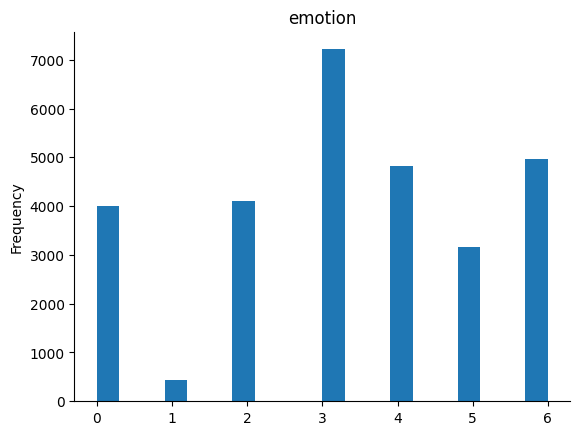

In [ ]:
df['emotion'].plot(kind='hist', bins=20, title='emotion')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df1 = pd.read_csv('/content/icml_face_data.csv')
df1.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
def prepare_data(data):
    img_array = np.zeros(shape=(len(data), 48, 48))
    img_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        img = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        img = np.reshape(img, (48, 48))
        img_array[i] = img
    return img_array, img_label

In [ ]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [ ]:
df1[' Usage'].value_counts()

 Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

## **Data Preprocessing**

In [ ]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [ ]:
train_image_array, train_image_label = prepare_data(df1[df1[' Usage']=='Training'])
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255

val_image_array, val_image_label = prepare_data(df1[df1[' Usage']=='PrivateTest'])
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255

test_image_array, test_image_label = prepare_data(df1[df1[' Usage']=='PublicTest'])
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [ ]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

In [ ]:
class_weight = dict(zip(range(0, 7), (((df1[df1[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(df1[df1[' Usage']=='Training']['emotion'])).tolist()))

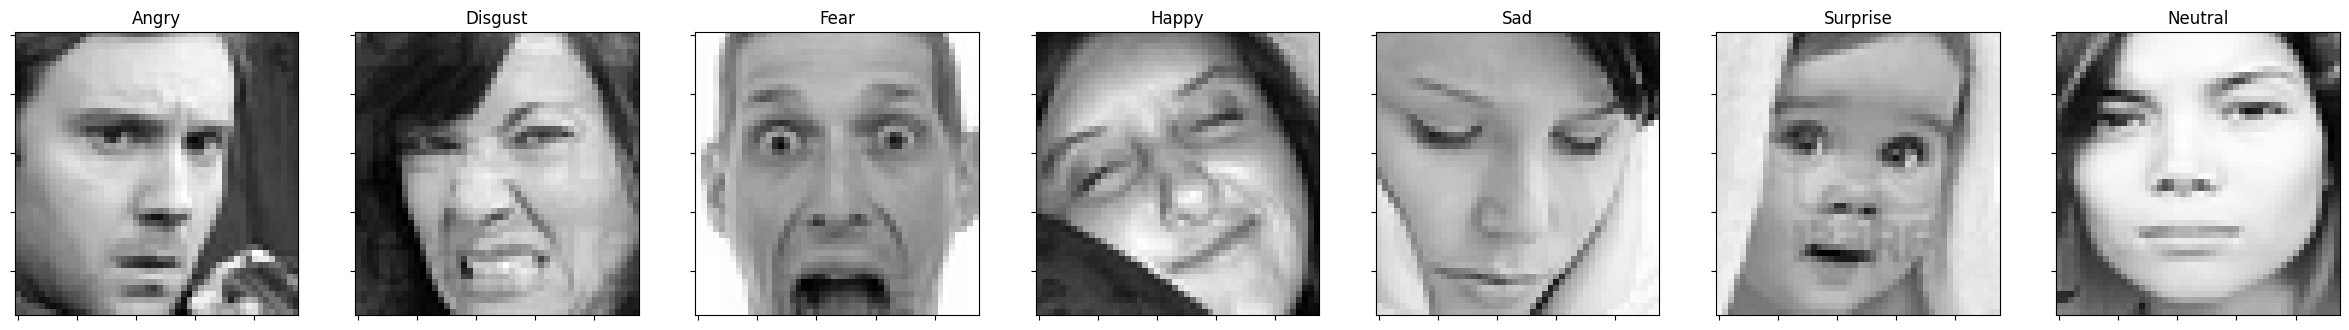

In [ ]:
fig, axs = plt.subplots(1, 7, figsize=(30, 12))
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
for i in range(7):
    idx = df1[df1['emotion']==i].index[i]
    axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
    axs[i].set_title(emotions[train_labels[idx].argmax()])
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])

## **Model Building**

In [ ]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 4096)              0

## **Model Training**

In [ ]:
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=10,
                    batch_size=64)

Epoch 1/10
449/449 [==============================] - 104s 226ms/step - loss: 0.2646 - accuracy: 0.3243 - val_loss: 1.5746 - val_accuracy: 0.4001
Epoch 2/10
449/449 [==============================] - 96s 214ms/step - loss: 0.2232 - accuracy: 0.4444 - val_loss: 1.4680 - val_accuracy: 0.4497
Epoch 3/10
449/449 [==============================] - 98s 219ms/step - loss: 0.2048 - accuracy: 0.4931 - val_loss: 1.4118 - val_accuracy: 0.4759
Epoch 4/10
449/449 [==============================] - 100s 222ms/step - loss: 0.1928 - accuracy: 0.5232 - val_loss: 1.2962 - val_accuracy: 0.5085
Epoch 5/10
449/449 [==============================] - 97s 217ms/step - loss: 0.1830 - accuracy: 0.5484 - val_loss: 1.2682 - val_accuracy: 0.5261
Epoch 6/10
449/449 [==============================] - 96s 214ms/step - loss: 0.1735 - accuracy: 0.5710 - val_loss: 1.2428 - val_accuracy: 0.5383
Epoch 7/10
449/449 [==============================] - 98s 217ms/step - loss: 0.1656 - accuracy: 0.5943 - val_loss: 1.2372 - val_

## **Model Testing**

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)
pred_test_labels = model.predict(test_images)

113/113 [==============================] - 3s 23ms/step - loss: 1.2788 - accuracy: 0.5489
test caccuracy: 0.5488994121551514
113/113 [==============================] - 4s 34ms/step


In [ ]:
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    bar_label = emotions.values()
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])

    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()

    plt.show()

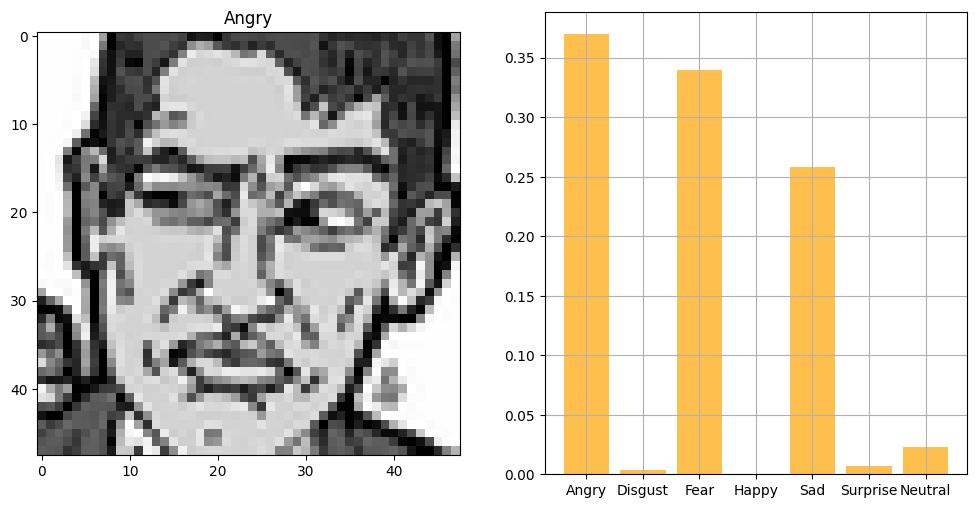

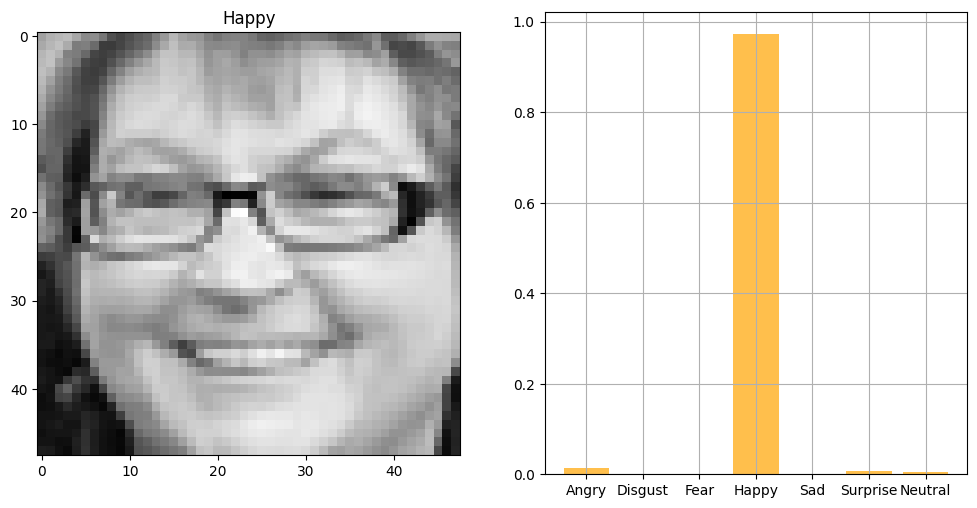

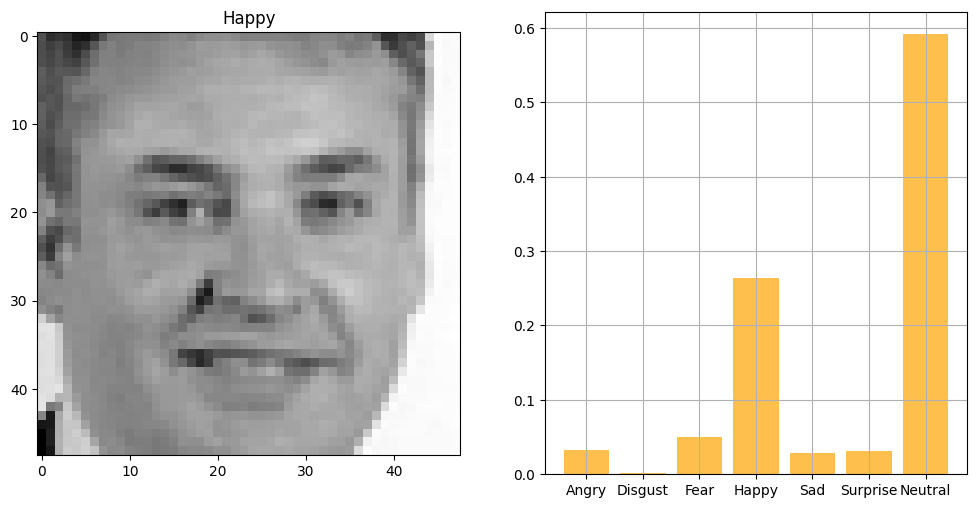

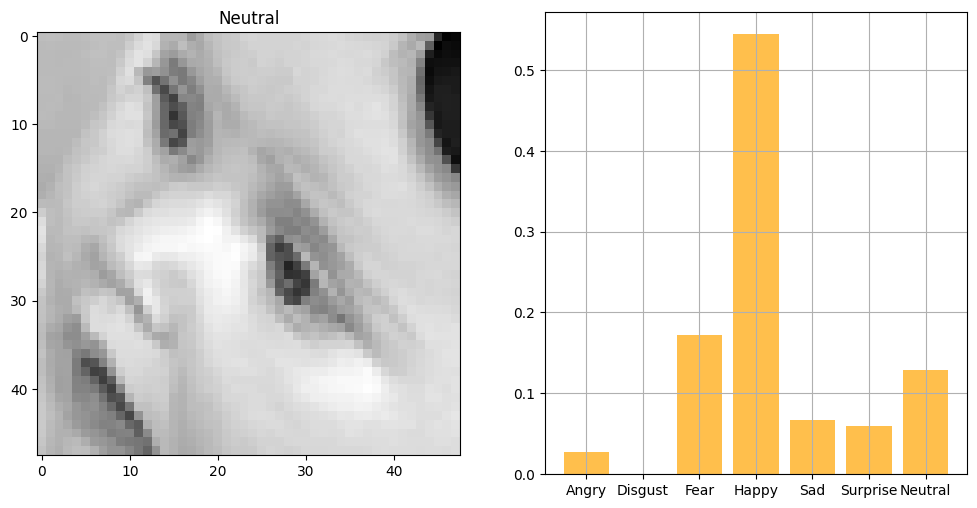

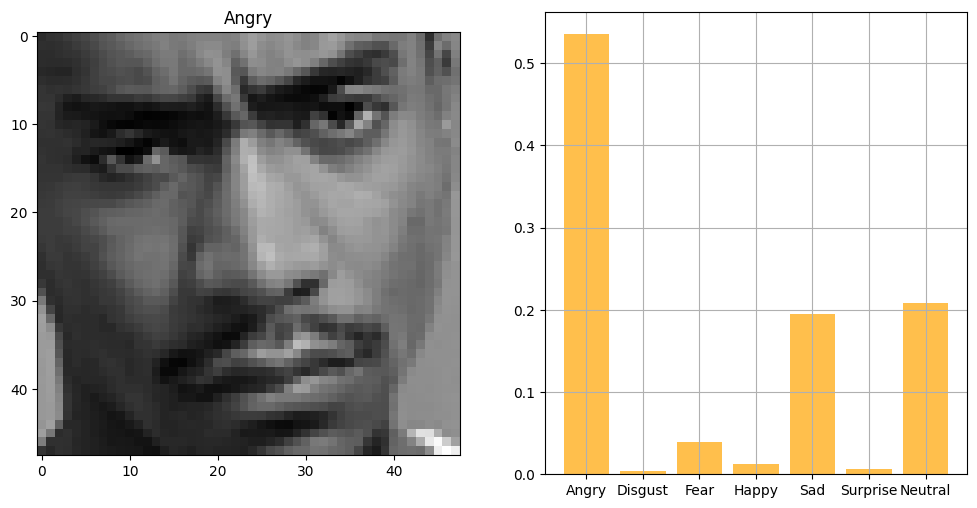

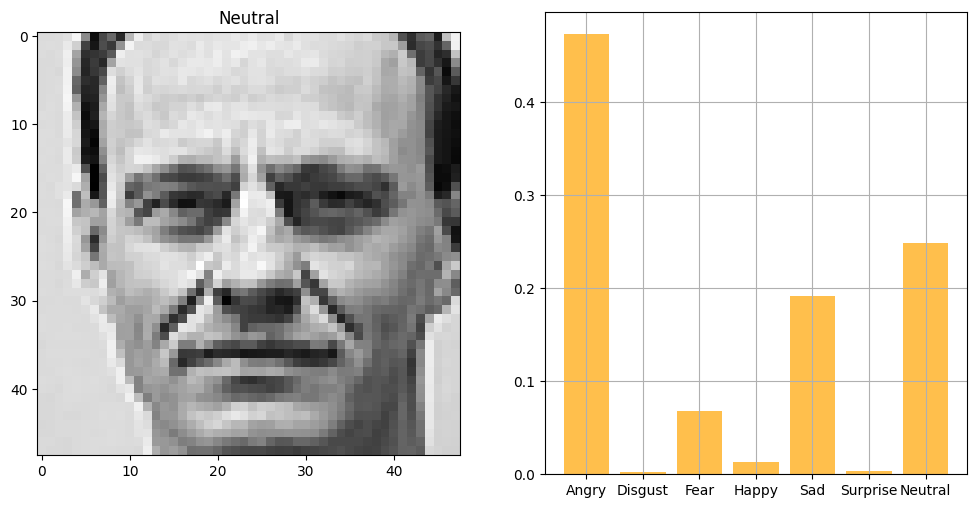

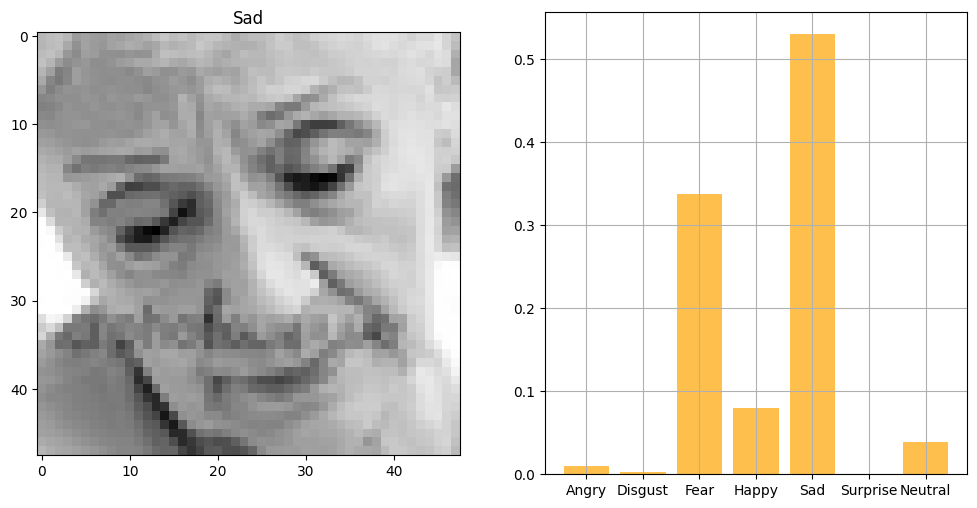

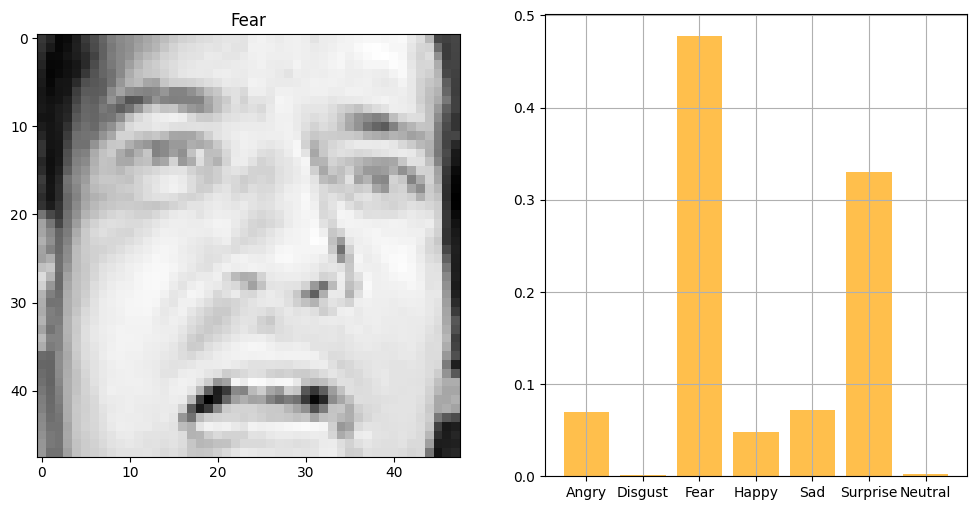

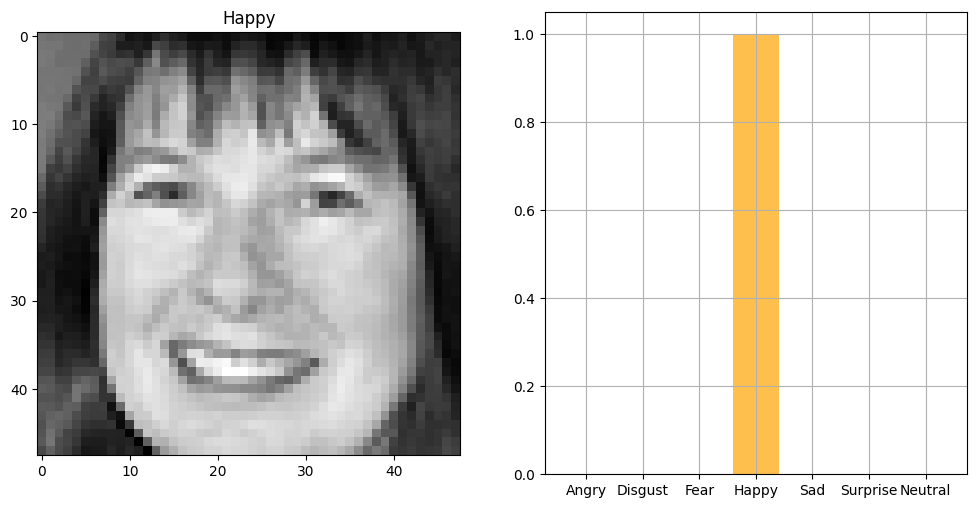

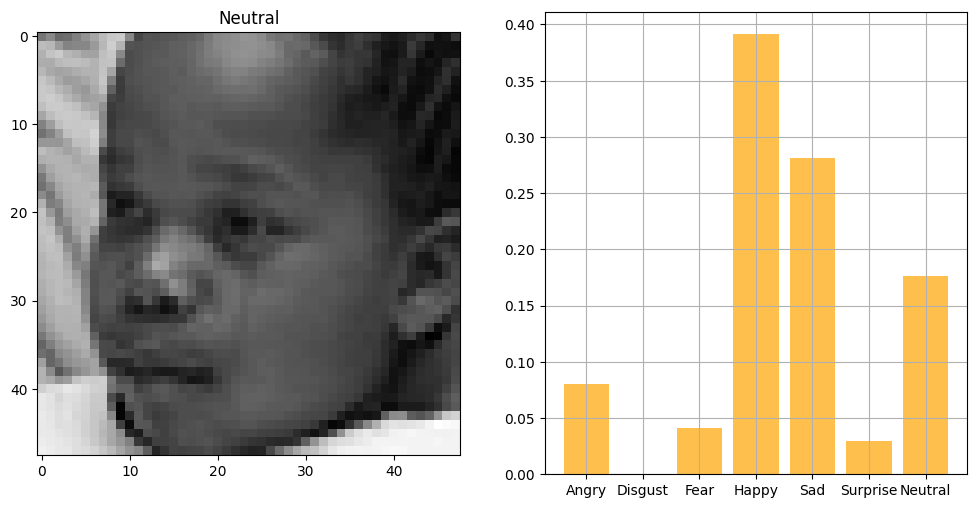

In [ ]:
for i in range(0,1000,100):
  plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels,i )

## **Confusion Matrix**

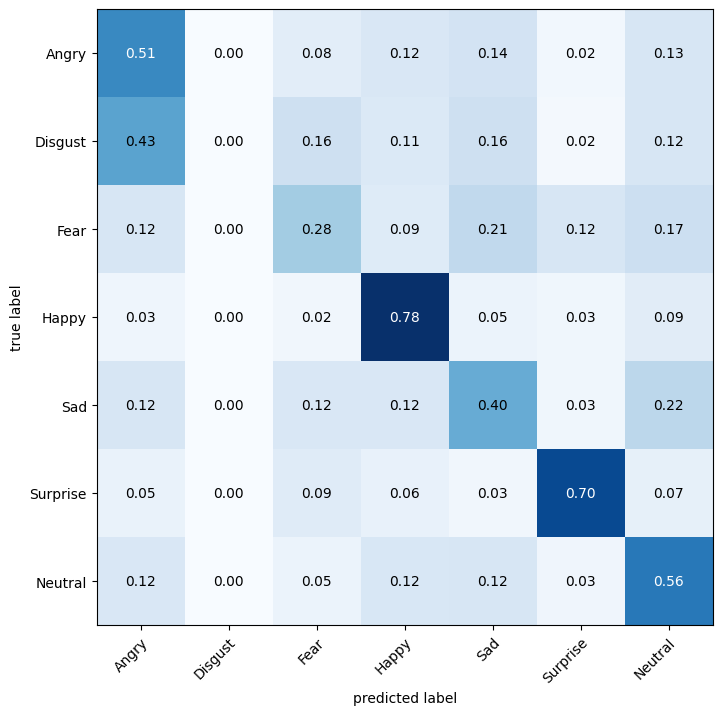

In [ ]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

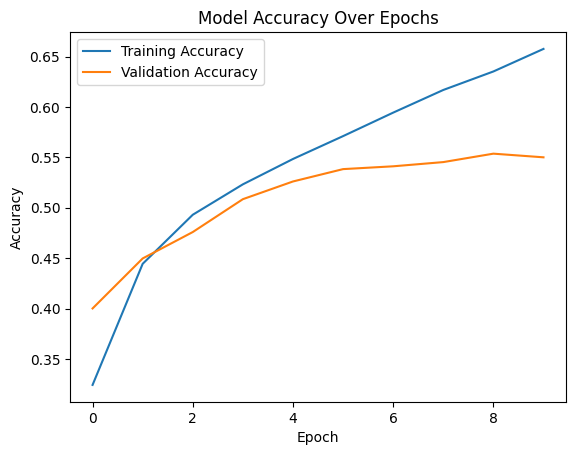

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.show()

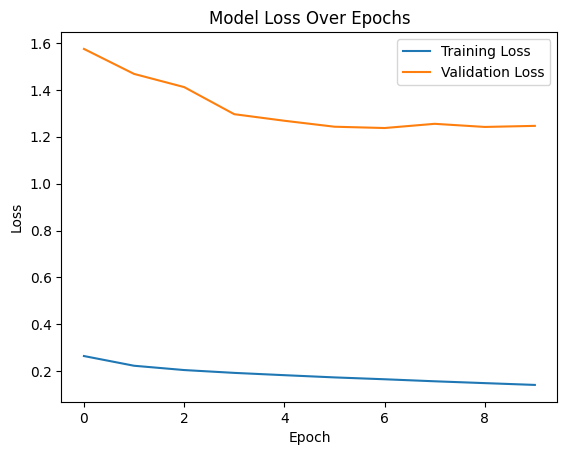

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
model.save('model_5.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
